In [6]:
import torch
from PIL import Image
from torchvision import transforms
import pickle
from model import EncoderCNN,DecoderRNN
from build_vocab import Vocabulary
import argparse
import numpy as np
import matplotlib.pyplot as plt

In [7]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
def load_image(image_path,transform = None):
    image = Image.open(image_path)
    image = image.resize([224,224] , Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
        
    return image

In [9]:
def main(args):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])
    
    with open(args.vocab_path , 'rb') as f:
        vocab = pickle.load(f)
        
    encoder = EncoderCNN(args.embed_size).eval()
    decoder = DecoderRNN(len(vocab),args.embed_size,args.hidden_size,args.num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    encoder.load_state_dict(torch.load(args.encoder_path,map_location='cpu'))
    decoder.load_state_dict(torch.load(args.decoder_path,map_location='cpu'))
    
    
    image = load_image(args.image,transform)
    image_tensor = image.to(device)
    
    feature = encoder(image_tensor)
    sample_ids = decoder.sample(feature)
    sample_ids = sample_ids[0].cpu().numpy()
    
    sample_caption = []
    for word_id in sample_ids:
        word = vocab.idx2word[word_id]
        sample_caption.append(word)
        if word == '<end>':
            break
    sentence =' '.join(sample_caption)
    
    
    image = Image.open(args.image)
    plt.imshow(np.asarray(image))
    print(sentence)

<start> a little girl holding a toothbrush in her hand . <end>


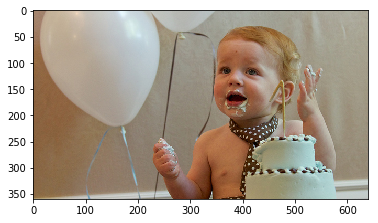

In [33]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--image',type = str ,default = 'data/val2014/COCO_val2014_000000000428.jpg' , help = 'input image for generating captions')
    parser.add_argument('--vocab_path',type = str , default = 'data/vocab.pkl' , help = 'this is the path for vocabulary wrapper')
    parser.add_argument('--encoder_path',type = str , default = 'models/encoder-1-2000.ckpt' ,help = 'path for trained encoder')
    parser.add_argument('--decoder_path', type = str , default = 'models/decoder-1-2000.ckpt' ,help = 'path for trained decoder')
    
    parser.add_argument('--embed_size',type = int ,default = 256 , help = 'dimension for word embedding vector')
    parser.add_argument('--hidden_size',type= int ,default = 512 , help = 'dimension for lstm hidden states')
    parser.add_argument('--num_layers',type = int ,default = 1 , help = 'number of layers in lstm')
    
    args = parser.parse_args(args=[])
    main(args)